In [1]:
#importing libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
df = np.array(pd.read_csv('fea.csv' , header = None))

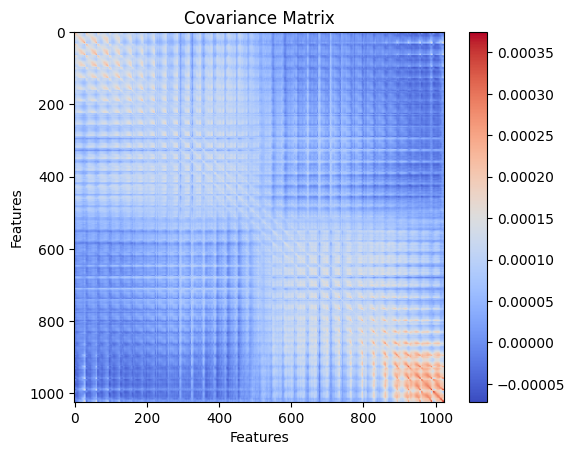

In [72]:
cov_matrix = np.cov(df, rowvar=False)

# Display covariance matrix as a heatmap
plt.imshow(cov_matrix, cmap='coolwarm')
plt.colorbar()
plt.title('Covariance Matrix without PCA')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [58]:
## unit normalisation

df = df / np.linalg.norm(df , axis = 0)

In [59]:

def apply_pca(df, k):
    X_mean = np.mean(df, axis=0)
    df = df - X_mean

    # Computing the covariance matrix
    covariance_matrix = np.cov(df, rowvar=False)

    # Computing the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)


    # Sorting the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Selecting the top k eigenvectors based on the desired number of components
    selected_eigenvectors = eigenvectors[:, :k]

    # Transforming the data to the reduced-dimensional space
    df_pca = np.dot(df, selected_eigenvectors)

    return df_pca


In [60]:
df.shape

(1700, 1024)

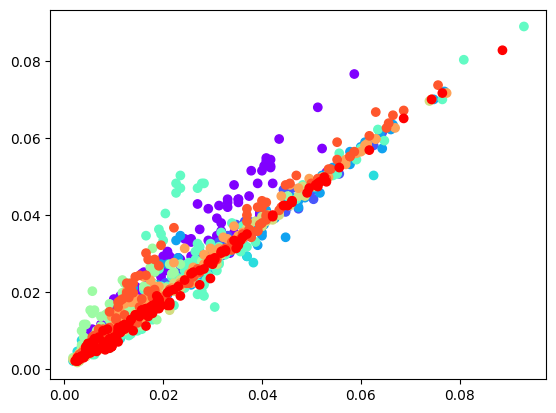

In [61]:

#plotting first two features of the data
plt.scatter(df[:,0], df[:,1], c=labels, cmap='rainbow')

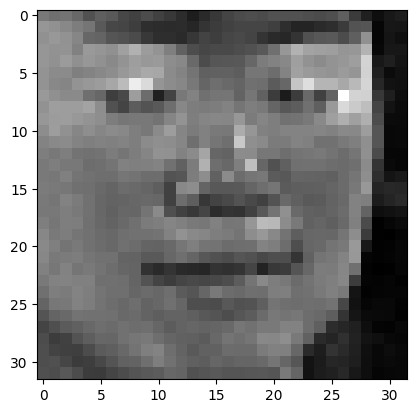

In [62]:
# sample picture 

plt.imshow(df[0].reshape(32,32).T ,  cmap='gray') 

In [63]:
#labeling the data
my_array = df

rows_per_label = 170

num_rows = my_array.shape[0]

num_labels = num_rows // rows_per_label

labels = np.empty((num_rows,), dtype=int)

for i in range(num_labels):
    start = i * rows_per_label
    end = (i + 1) * rows_per_label
    labels[start:end] = i 
print(labels)


[0 0 0 ... 9 9 9]


In [64]:
def create_train_test(num_subjects , num_images_per_subject , num_training_images_per_subject  , num_splits):
    train_indices_list = []
    test_indices_list = []

    for split in range(num_splits):
        train_indices = np.empty((0,), dtype=int)
        test_indices = np.empty((0,), dtype=int)
        
        for subject in range(num_subjects):
            subject_indices = np.arange(subject * num_images_per_subject, (subject + 1) * num_images_per_subject)
            np.random.shuffle(subject_indices)
            train_subject_indices = subject_indices[:num_training_images_per_subject]
            test_subject_indices = subject_indices[num_training_images_per_subject:num_images_per_subject]
            
            train_indices = np.concatenate((train_indices, train_subject_indices))
            test_indices = np.concatenate((test_indices, test_subject_indices))
        
        train_indices_list.append(train_indices)
        test_indices_list.append(test_indices)

    train_indices_array = np.array(train_indices_list)
    test_indices_array = np.array(test_indices_list)

    return train_indices_array, test_indices_array

In [65]:
from collections import Counter

class KNN:
    def __init__(self, k , distance = 'euclidean'):
        self.k = k
        self.distance = distance

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        if len(X.shape) == 1:
            return self._predict(X)
        if self.distance == 'euclidean':
            #using single for loop
            distances = np.empty((X.shape[0], self.X_train.shape[0]))
            for i in range(X.shape[0]):
                distances[i] = np.sqrt(np.sum((X[i] - self.X_train)**2, axis=1))

        elif self.distance == 'mahalanobis':
            #using single for loop

            distances = np.empty((X.shape[0], self.X_train.shape[0]))
            inv_cov = np.linalg.inv(np.cov(self.X_train.T))
            for i in range(X.shape[0]):
                distances[i] = np.sqrt(np.sum((X[i] - self.X_train).dot(inv_cov) * (X[i] - self.X_train), axis=1))

        elif self.distance == 'cosine':
            norms_X = np.linalg.norm(X, axis=1)
            norms_X_train = np.linalg.norm(self.X_train, axis=1)
            distances = np.dot(X, self.X_train.T) / np.outer(norms_X, norms_X_train)
        else:
            raise ValueError("Invalid distance function")
        
        y_pred = np.empty((X.shape[0],), dtype=int)
        for i in range(X.shape[0]):
            k_indices = np.argsort(distances[i])[:self.k]
            k_labels = self.y_train[k_indices]
            y_pred[i] = Counter(k_labels).most_common(1)[0][0]
        return y_pred
    
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / len(y_test)
        return accuracy
    


In [66]:
def run_model(train, test, df , labels):
    X_train = df[train[0]]
    y_train = labels[train[0]]
    X_test = df[test[0]]
    y_test = labels[test[0]]


    #training the model

    clf = KNN(k=4 , distance = 'mahalanobis')
    clf.fit(X_train, y_train)

    #testing the model

    y_pred = clf.predict(X_test)

    #accuracy of the model

    return clf.score(X_test, y_test) , y_pred , y_test

# training data with 5 random splits without pca

In [9]:
train , test =create_train_test(10,170,150,5)

In [10]:
train.shape , test.shape

((5, 1500), (5, 200))

# experimenting for optimized value of k for knn 

#### Eucliedean distance

In [22]:
for i in range(5):
    acc = np.zeros(9)
    for k in range(1,10):
        clf = KNN(k=k , distance = 'euclidean')
        clf.fit(df[train[i]], labels[train[i]])
        acc[k-1] = clf.score(df[test[i]], labels[test[i]])

    # average std and average accuracy
    print('Average accuracy for split {} is {}'.format(i+1,np.mean(acc)))
    print('Average std for split {} is {}'.format(i+1,np.std(acc)))

Average accuracy for split 1 is 0.9644444444444444
Average std for split 1 is 0.01817269692644013
Average accuracy for split 2 is 0.9622222222222222
Average std for split 2 is 0.016348821077291305
Average accuracy for split 3 is 0.9583333333333334
Average std for split 3 is 0.01943650631615099
Average accuracy for split 4 is 0.9411111111111112
Average std for split 4 is 0.0275658582890117
Average accuracy for split 5 is 0.9472222222222223
Average std for split 5 is 0.02749859704614349


#### Cosine 

In [25]:
for i in range(5):
    acc = np.zeros(9)
    for k in range(1,10):
        clf = KNN(k=k , distance = 'cosine')
        clf.fit(df[train[i]], labels[train[i]])
        acc[k-1] = clf.score(df[test[i]], labels[test[i]])

    # average std and average accuracy
    print('Average accuracy for split {} is {}'.format(i+1,np.mean(acc)))
    print('Average std for split {} is {}'.format(i+1,np.std(acc)))

Average accuracy for split 1 is 0.07166666666666668
Average std for split 1 is 0.012472191289246475
Average accuracy for split 2 is 0.04555555555555555
Average std for split 2 is 0.008642416214502248
Average accuracy for split 3 is 0.04611111111111111
Average std for split 3 is 0.006136311676215145
Average accuracy for split 4 is 0.02666666666666667
Average std for split 4 is 0.006666666666666667
Average accuracy for split 5 is 0.05611111111111111
Average std for split 5 is 0.009362388636862621


#### Mahalanobis distance

In [24]:
for i in range(5):
    acc = np.zeros(9)
    for k in range(1,10):
        clf = KNN(k=k , distance = 'mahalanobis')
        clf.fit(df[train[i]], labels[train[i]])
        acc[k-1] = clf.score(df[test[i]], labels[test[i]])

    # average std and average accuracy
    print('Average accuracy for split {} is {}'.format(i+1,np.mean(acc)))
    print('Average std for split {} is {}'.format(i+1,np.std(acc)))

Average accuracy for split 1 is 0.7766666666666667
Average std for split 1 is 0.08576453553512405
Average accuracy for split 2 is 0.8066666666666666
Average std for split 2 is 0.08141116494546542
Average accuracy for split 3 is 0.8083333333333332
Average std for split 3 is 0.07767453465154028
Average accuracy for split 4 is 0.7966666666666666
Average std for split 4 is 0.09823441352194251
Average accuracy for split 5 is 0.7694444444444444
Average std for split 5 is 0.08480187512485414


# using lesser classes for training




#### using first 5 classes 

In [32]:
less_train , less_test =create_train_test(5,170,150,5)

In [33]:
less_train.shape ,  less_test.shape

((5, 750), (5, 100))

In [35]:
for i in range(5):
    acc = np.zeros(9)
    for k in range(1,10):
        clf = KNN(k=k , distance = 'euclidean')
        clf.fit(df[less_train[i]], labels[less_train[i]])
        acc[k-1] = clf.score(df[less_test[i]], labels[less_test[i]])

    # average std and average accuracy
    print('Average accuracy for split {} is {}'.format(i+1,np.mean(acc)))
    print('Average std for split {} is {}'.format(i+1,np.std(acc)))

Average accuracy for split 1 is 0.9522222222222223
Average std for split 1 is 0.029355210696939773
Average accuracy for split 2 is 0.98
Average std for split 2 is 0.015634719199411447
Average accuracy for split 3 is 0.9766666666666666
Average std for split 3 is 0.019436506316151018
Average accuracy for split 4 is 0.9599999999999999
Average std for split 4 is 0.025385910352879702
Average accuracy for split 5 is 0.9622222222222222
Average std for split 5 is 0.030469576001782413


#### using first 3 classes

In [37]:
less_train , less_test =create_train_test(3,170,150,5)

for i in range(5):
    acc = np.zeros(9)
    for k in range(1,10):
        clf = KNN(k=k , distance = 'euclidean')
        clf.fit(df[less_train[i]], labels[less_train[i]])
        acc[k-1] = clf.score(df[less_test[i]], labels[less_test[i]])

    # average std and average accuracy
    print('Average accuracy for split {} is {}'.format(i+1,np.mean(acc)))
    print('Average std for split {} is {}'.format(i+1,np.std(acc)))

Average accuracy for split 1 is 0.974074074074074
Average std for split 1 is 0.008281733249999193
Average accuracy for split 2 is 0.9611111111111109
Average std for split 2 is 0.020786985482077473
Average accuracy for split 3 is 0.9666666666666666
Average std for split 3 is 0.019245008972987542
Average accuracy for split 4 is 0.9907407407407407
Average std for split 4 is 0.011415581486979597
Average accuracy for split 5 is 1.0
Average std for split 5 is 0.0


#### using less number of training samples

In [39]:
less_train_ex , less_test_ex =create_train_test(10,170,100,5)
for i in range(5):
    acc = np.zeros(9)
    for k in range(1,10):
        clf = KNN(k=k , distance = 'euclidean')
        clf.fit(df[less_train_ex[i]], labels[less_train_ex[i]])
        acc[k-1] = clf.score(df[less_test_ex[i]], labels[less_test_ex[i]])

    # average std and average accuracy
    print('Average accuracy for split {} is {}'.format(i+1,np.mean(acc)))
    print('Average std for split {} is {}'.format(i+1,np.std(acc)))

Average accuracy for split 1 is 0.9182539682539682
Average std for split 1 is 0.03486142165891439
Average accuracy for split 2 is 0.9001587301587303
Average std for split 2 is 0.038216737464411905
Average accuracy for split 3 is 0.9203174603174603
Average std for split 3 is 0.033885078407386464
Average accuracy for split 4 is 0.9026984126984127
Average std for split 4 is 0.03310427724756497
Average accuracy for split 5 is 0.9266666666666666
Average std for split 5 is 0.02859522818286177


#### using pca for features dimenation reduction

In [73]:
pca_data=apply_pca(df,120 )

pca_data.shape

(1700, 120)

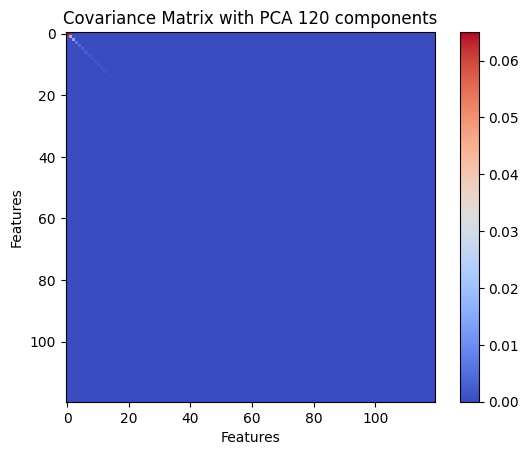

In [75]:
cov_matrix = np.cov(pca_data, rowvar=False)

# Display covariance matrix as a heatmap
plt.imshow(cov_matrix, cmap='coolwarm')
plt.colorbar()
plt.title('Covariance Matrix with PCA 120 components')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [51]:
less_train_ex , less_test_ex =create_train_test(10,170,150,5)
for i in range(5):
    acc = np.zeros(9)
    for k in range(1,10):
        clf = KNN(k=k , distance = 'euclidean')
        clf.fit(pca_data[less_train_ex[i]], labels[less_train_ex[i]])
        acc[k-1] = clf.score(pca_data[less_test_ex[i]],  labels[less_test_ex[i]])

    # average std and average accuracy
    print('Average accuracy for split {} is {}'.format(i+1,np.mean(acc)))
    print('Average std for split {} is {}'.format(i+1,np.std(acc)))

Average accuracy for split 1 is 0.9327777777777779
Average std for split 1 is 0.03101174608211745
Average accuracy for split 2 is 0.916111111111111
Average std for split 2 is 0.03619221661089406
Average accuracy for split 3 is 0.9266666666666666
Average std for split 3 is 0.04672615256292061
Average accuracy for split 4 is 0.9088888888888889
Average std for split 4 is 0.032979604621457395
Average accuracy for split 5 is 0.9477777777777777
Average std for split 5 is 0.017014880923459486


In [71]:
less_train_ex , less_test_ex =create_train_test(10,170,150,5)
for i in range(5):
    acc = np.zeros(9)
    for k in range(1,10):
        clf = KNN(k=k , distance = 'mahalanobis')
        clf.fit(pca_data[less_train_ex[i]], labels[less_train_ex[i]])
        acc[k-1] = clf.score(pca_data[less_test_ex[i]], labels[less_test_ex[i]])

    # average std and average accuracy
    print('Average accuracy for split {} is {}'.format(i+1,np.mean(acc)))
    print('Average std for split {} is {}'.format(i+1,np.std(acc)))

Average accuracy for split 1 is 0.9650000000000001
Average std for split 1 is 0.005773502691896262
Average accuracy for split 2 is 0.98
Average std for split 2 is 0.006236095644623241
Average accuracy for split 3 is 0.9838888888888889
Average std for split 3 is 0.009654526220545991
Average accuracy for split 4 is 0.9761111111111112
Average std for split 4 is 0.003928371006591934
Average accuracy for split 5 is 0.9700000000000001
Average std for split 5 is 0.009428090415820642


In [54]:
less_train_ex , less_test_ex =create_train_test(10,170,150,5)
for i in range(5):
    acc = np.zeros(9)
    for k in range(1,10):
        clf = KNN(k=k , distance = 'cosine')
        clf.fit(pca_data[less_train_ex[i]], labels[less_train_ex[i]])
        acc[k-1] = clf.score(pca_data[less_test_ex[i]], labels[less_test_ex[i]])

    # average std and average accuracy
    print('Average accuracy for split {} is {}'.format(i+1,np.mean(acc)))
    print('Average std for split {} is {}'.format(i+1,np.std(acc)))

Average accuracy for split 1 is 0.021111111111111112
Average std for split 1 is 0.003928371006591932
Average accuracy for split 2 is 0.01666666666666667
Average std for split 2 is 0.004082482904638631
Average accuracy for split 3 is 0.022777777777777775
Average std for split 3 is 0.0047790695928014585
Average accuracy for split 4 is 0.020555555555555556
Average std for split 4 is 0.006849348892187752
Average accuracy for split 5 is 0.007222222222222221
Average std for split 5 is 0.005826715823167509


#### experiment with different number of components

In [69]:
#choosing random number from 20 to 500
while (True ):
    n_c =  int(np.random.randint(20,500,1))
    print(n_c)
    pca_data=apply_pca(df, n_c)
    less_train_ex , less_test_ex =create_train_test(10,170,150,1)
    clf = KNN(k=k , distance = 'mahalanobis')
    clf.fit(pca_data[less_train_ex[0]], labels[less_train_ex[0]])
    #accuracy with n-component
    acc = clf.score(pca_data[less_test_ex[0]], labels[less_test_ex[0]])
    print('Average accuracy for no of components  {} is {}'.format(n_c,acc))
    if acc > 0.98:
        break
    


296
Average accuracy for no of components  296 is 0.955
404
Average accuracy for no of components  404 is 0.945
382
Average accuracy for no of components  382 is 0.95
207
Average accuracy for no of components  207 is 0.945
161
Average accuracy for no of components  161 is 0.955
236
Average accuracy for no of components  236 is 0.935
459
Average accuracy for no of components  459 is 0.855
257
Average accuracy for no of components  257 is 0.92
206
Average accuracy for no of components  206 is 0.95
366
Average accuracy for no of components  366 is 0.98
438
Average accuracy for no of components  438 is 0.91
346
Average accuracy for no of components  346 is 0.93
249
Average accuracy for no of components  249 is 0.965
470
Average accuracy for no of components  470 is 0.905
484
Average accuracy for no of components  484 is 0.89
177
Average accuracy for no of components  177 is 0.97
104
Average accuracy for no of components  104 is 0.97
386
Average accuracy for no of components  386 is 0.89
10

KeyboardInterrupt: 